In [22]:
import cirq
import numpy as np

In [23]:
def H_p(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            HCircuit.append(cirq.rz(gamma * C[i][j])(cirq.LineQubit(j)))
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
    return HCircuit

def H_d(N, beta):
    dCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(N):
        dCircuit.append(cirq.rx(beta)(cirq.LineQubit(i)))
    return dCircuit

def H_pZZ(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
    return HCircuit

In [24]:
def f(x):
    return 1 - (1-x)**2

                        ┌────────┐   ┌────────┐   ┌────────┐                                                      ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐                                                                ┌─────────────────┐   ┌────────────────┐   ┌────────────────┐                                                                 ┌────────────────┐   ┌───────────────┐   ┌───────────────────┐                                                             ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐
0: ───H───ZZ─────ZZ──────ZZ───────────ZZ─────────────────────────────────────Rx(-0.637π)───ZZ──────────ZZ──────────ZZ───────────────────ZZ────────────────────────────────────────────────────────────────Rx(-0.591π)───ZZ───────────ZZ─────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────Rx(-0.555π)───ZZ──────────ZZ─────────ZZ───────────────────ZZ─────────────────────────────────────────────────────────────

/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

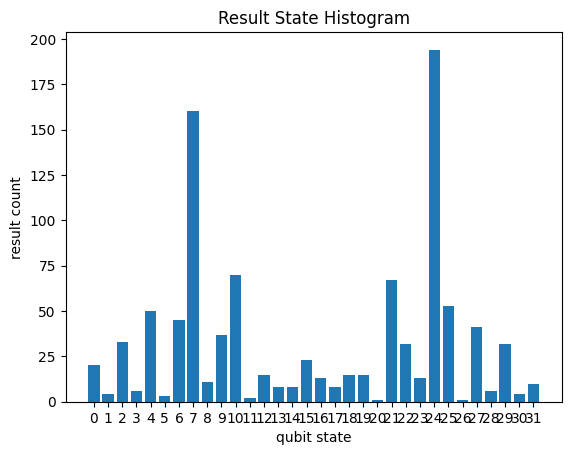

In [25]:
#################################TEST#############################################
costMat = [[0, .12, .05, .83, .76],
           [0, 0, .09, .95, .69],
           [0, 0, 0, .98, .87],
           [0, 0, 0, 0, .12],
           [0, 0, 0, 0, 0],]
costMat = np.array(costMat)
for i in range(len(costMat)):
    for j in range(len(costMat)):
        costMat[i][j] = costMat[i][j] * 100

N = 5

testCircuit = cirq.Circuit()
testQubits = cirq.LineQubit.range(N)

testCircuit.append(cirq.H.on_each(*testQubits))

T = 1.0
numIterations = 20
dt = .2

for t in np.arange(0, T, dt):
    d = 1 - f(t/T)
    pAngle = (-2 * f(t/T) * dt)
    dAngle = (-2 * (1 - f(t/T) * dt))   #this angle for the driver hamiltonian is basically equivalent to setting it to a constant value

    testCircuit.append(H_pZZ(costMat, pAngle, N))   #for some reason using the normal H_p doesn't work
    testCircuit.append(H_d(N, dAngle))

testCircuit.append(cirq.measure(*testQubits, key='z'))
print(testCircuit)


counts = 1000

simulator = cirq.Simulator()
samples =  simulator.run(testCircuit, repetitions=counts)

data = samples.histogram(key='z')
cirq.plot_state_histogram(data)

##################################TEST############################################
#correct answer should be 7 or 24


In [26]:
def singleGateError(circuit, qubit):
    prob = np.random.random()
    if prob < 0.0005:
        print("singleGateError ", prob)
        gate = np.random.choice(range(3))
        if gate == 0:
            circuit.append(cirq.X(qubit))
        if gate == 1:
            circuit.append(cirq.Y(qubit))
        if gate == 2:
            circuit.append(cirq.Z(qubit))
def CNOTError(circuit, qubits):
    prob = np.random.random()
    if prob < 0.005:
        print("CNOT Error: ", prob)
        gate = np.random.choice(range(3))
        qubit = np.random.choice(range(2))
        if gate == 0:
            circuit.append(cirq.X(qubits[qubit]))
        if gate == 1:
            circuit.append(cirq.Y(qubits[qubit]))
        if gate == 2:
            circuit.append(cirq.Z(qubits[qubit]))

In [27]:
def NoisyH_p(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            CNOTError(HCircuit, qubits)
            HCircuit.append(cirq.rz(gamma * C[i][j])(cirq.LineQubit(j)))
            singleGateError(HCircuit, qubits)
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            CNOTError(HCircuit, qubits)
    return HCircuit

def NoisyH_d(N, beta):
    dCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(N):
        dCircuit.append(cirq.rx(beta)(cirq.LineQubit(i)))
        singleGateError(dCircuit, cirq.LineQubit(i))
    return dCircuit

def NoisyH_pZZ(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
            CNOTError(HCircuit, qubits)
            singleGateError(HCircuit, qubits)
            CNOTError(HCircuit, qubits)
    return HCircuit

CNOT Error:  0.0029445927503807257
CNOT Error:  0.0038621550891683176
                        ┌────────┐   ┌────────┐   ┌────────┐                                                      ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐                                                                ┌─────────────────┐   ┌────────────────┐   ┌────────────────┐                                                                 ┌────────────────┐   ┌───────────────┐   ┌───────────────────┐                                                             ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐
0: ───H───ZZ─────ZZ──────ZZ───────────ZZ─────────────────────────────────────Rx(-0.637π)───ZZ──────────ZZ──────────ZZ───────────────────ZZ───────────────────Y────────────────────X───────────────────────Rx(-0.591π)───ZZ───────────ZZ─────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────Rx(-0.555π)───ZZ──────────ZZ─────────ZZ────────────

/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

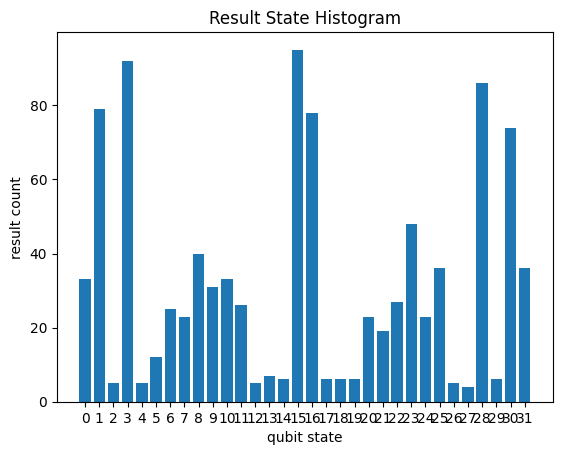

In [28]:
#################################NOISY-TEST#############################################
costMat = [[0, .12, .05, .83, .76],
           [0, 0, .09, .95, .69],
           [0, 0, 0, .98, .87],
           [0, 0, 0, 0, .12],
           [0, 0, 0, 0, 0],]
costMat = np.array(costMat)
for i in range(len(costMat)):
    for j in range(len(costMat)):
        costMat[i][j] = costMat[i][j] * 100

N = 5

testCircuit = cirq.Circuit()
testQubits = cirq.LineQubit.range(N)

testCircuit.append(cirq.H.on_each(*testQubits))

T = 1.0
dt = .2

for t in np.arange(0, T, dt):
    pAngle = (-2 * f(t/T) * dt)
    dAngle = (-2 * (1 - f(t/T) * dt))
    testCircuit.append(NoisyH_pZZ(costMat, pAngle, N))
    testCircuit.append(NoisyH_d(N, dAngle))

testCircuit.append(cirq.measure(*testQubits, key='z'))
print(testCircuit)


counts = 1000

simulator = cirq.Simulator()
samples =  simulator.run(testCircuit, repetitions=counts)

data = samples.histogram(key='z')
cirq.plot_state_histogram(data)

#################################NOISY-TEST#############################################
#correct answer should be 7 or 24
# for some reason this is single error fragile in its current state. 


P:  8 T:  4


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  8 T:  14


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  13 T:  4


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  13 T:  16


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  16 T:  12


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  16 T:  18
P:  17 T:  2


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  17 T:  3
P:  17 T:  6


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  17 T:  17
P:  17 T:  18


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  18 T:  11


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


P:  18 T:  14


/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Counter({26: 104, 12: 103, 19: 100, 3: 85, 5: 84, 28: 81, 8: 45, 23: 42, 20: 36, 11: 31, 15: 31, 13: 26, 2: 26, 31: 24, 0: 24, 6: 24, 16: 24, 29: 22, 25: 19, 22: 15, 18: 10, 1: 9, 9: 9, 4: 6, 10: 5, 7: 5, 27: 4, 21: 3, 30: 3})
26


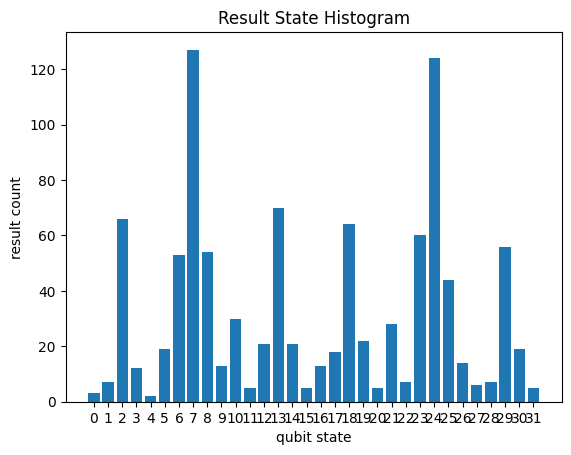

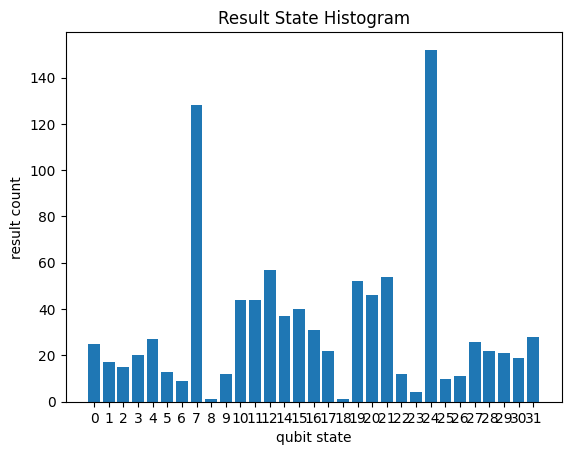

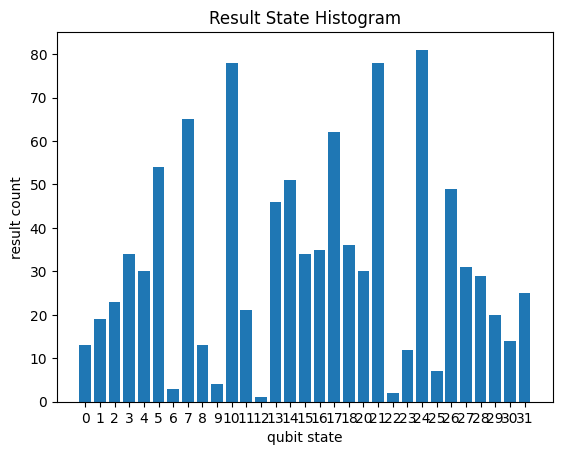

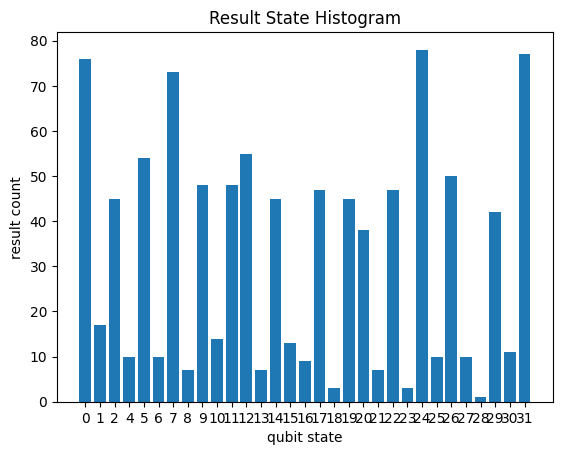

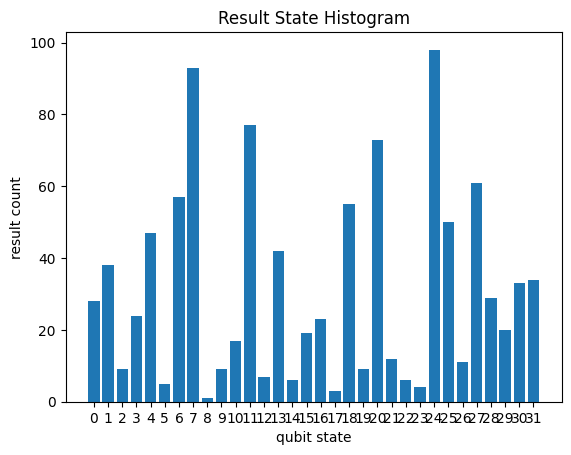

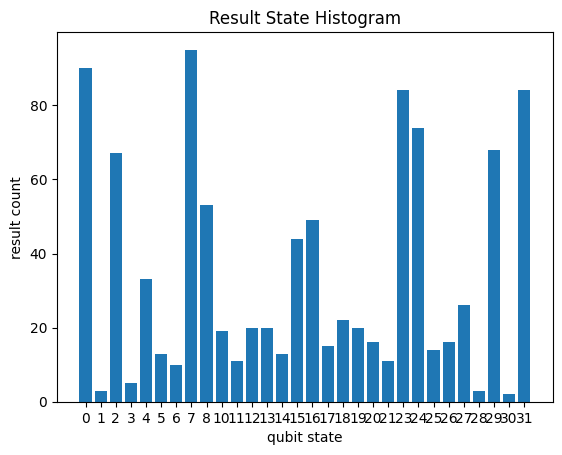

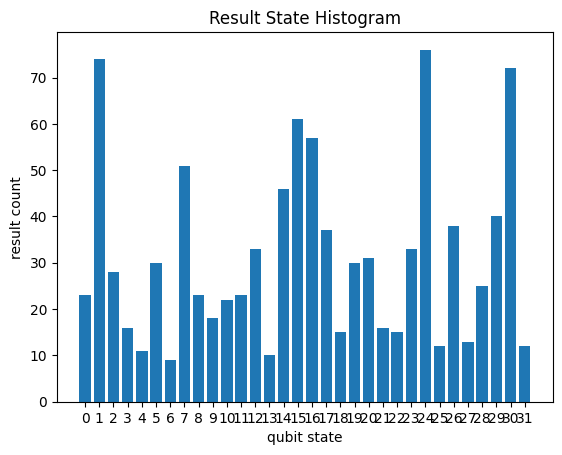

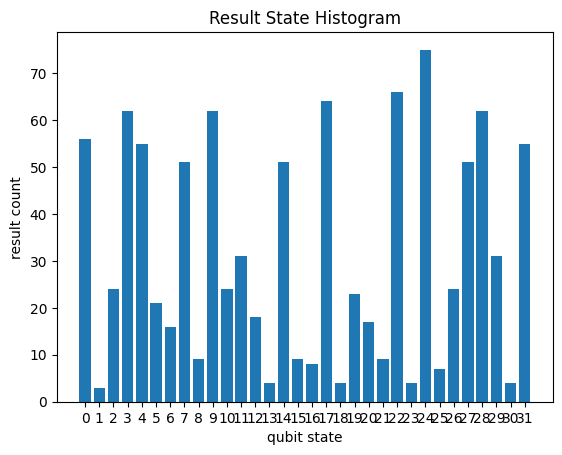

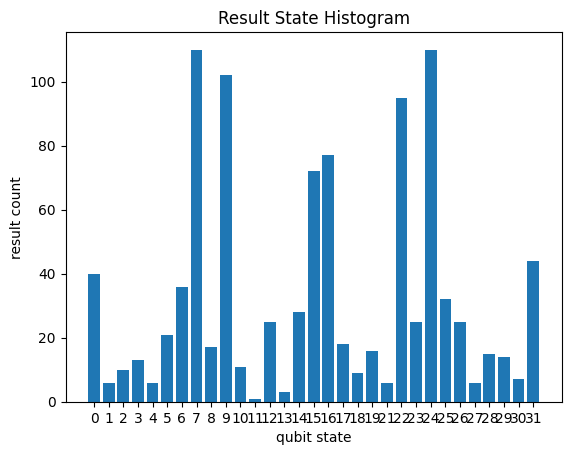

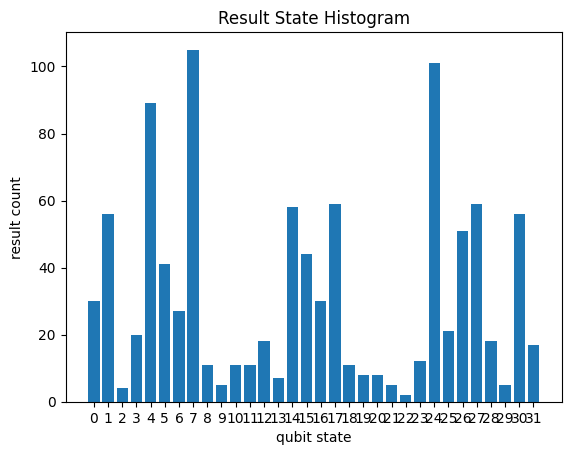

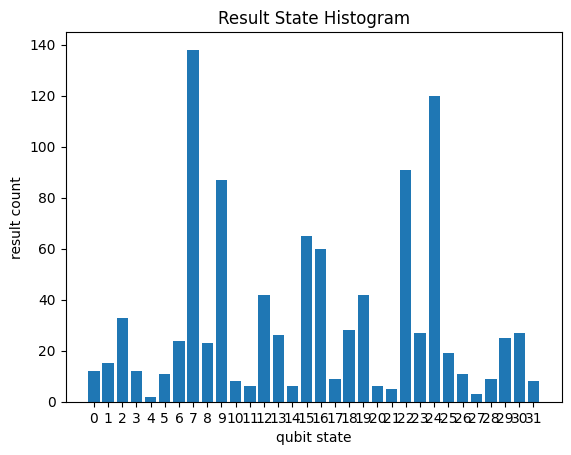

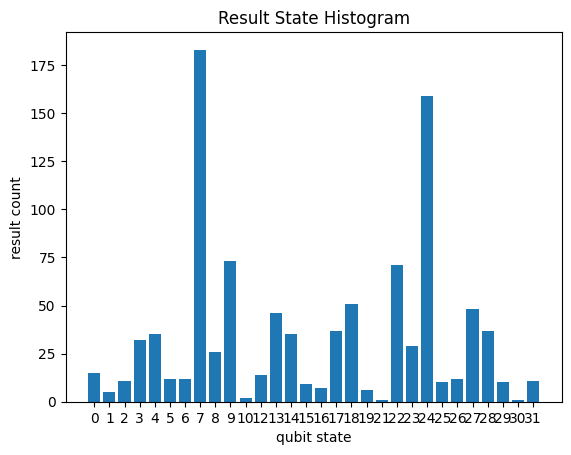

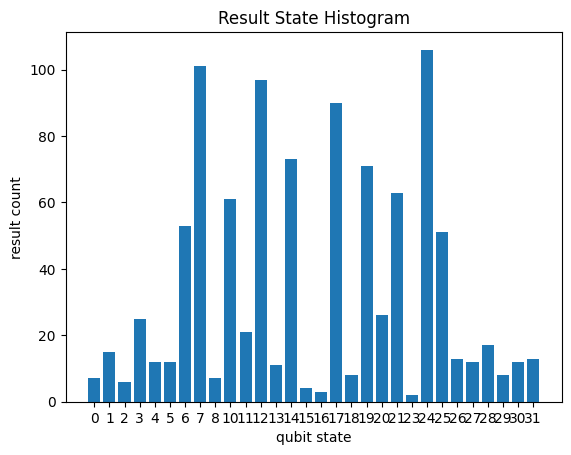

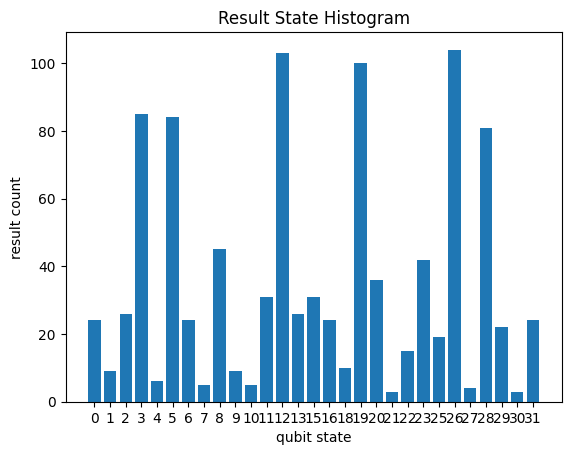

In [34]:
P = 10
T = 5
num_qubits = 5
exp = 0


def H_p(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            HCircuit.append(cirq.rz(gamma * C[i][j])(cirq.LineQubit(j)))
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
    return HCircuit

def H_d(N, beta):
    dCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(N):
        dCircuit.append(cirq.rx(beta)(cirq.LineQubit(i)))
    return dCircuit

def H_pZZ(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.rZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
            HCircuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
    return HCircuit





def calculate_expectation_value(state):
    exp_value = (-1)**(state[0]+state[1])
    
    return exp_value

for P in range(2, 20, 1):
    for T in range(1, 20, 1):

        vqeCircuit = cirq.Circuit()
        vqeQubits = cirq.LineQubit.range(num_qubits)

        vqeCircuit.append(cirq.H.on_each(*testQubits))


        for k in range(P):
            Hangle = 2 * (T/P) * f((k+1)/ (P+1))
            Dangle = 2 * (T/P) * (1 - f((k+1)/ (P+1)))
    
            vqeCircuit.append(H_p(costMat, Hangle, num_qubits))
            vqeCircuit.append(H_d(num_qubits, Dangle))
        vqeCircuit.append(cirq.measure(*vqeQubits, key='z'))

        counts = 1000

        simulator = cirq.Simulator()
        samples = simulator.run(vqeCircuit,repetitions=counts)

        data = samples.histogram(key='z')
        
        most_likely_state = 0
        most_instances = 0

        for i in range(2**num_qubits):
            if data[i] > most_instances:
                most_likely_state = i
                most_instances = data[i]
        if most_likely_state == 7 or most_likely_state == 24:
            print("P: ", P, "T: ", T)
            data = samples.histogram(key='z')
            cirq.plot_state_histogram(data)
        #print("P: ", P, "T: ", T, "most likely state: ", most_likely_state)



cirq.plot_state_histogram(data)
print(data)
print(most_likely_state)